# **Pneumonia Detection Challenge - Project**

In [1]:
# include all the imports here
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import pydicom

import matplotlib.pyplot as plt


### Step 1: Import the Data

#### Loading CSV files

In [2]:
# let us start with loading the csv files into dataframes
class_info = pd.read_csv('stage_2_detailed_class_info.csv')
sample_submission = pd.read_csv('stage_2_sample_submission.csv')
train_labels = pd.read_csv('stage_2_train_labels.csv')

# Display basic info about each of the dataframes
print('Detailed clas info shape:', class_info.shape)
print(class_info.head())
print("-"*80)

print('Sample Submission shape:', sample_submission.shape)
print(sample_submission.head())
print("-"*80)

print('Train Labels shape:', train_labels.shape)
print(train_labels.head())
print("-"*80)

# distribution ov classes
print(class_info['class'].value_counts())

Detailed clas info shape: (30227, 2)
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
--------------------------------------------------------------------------------
Sample Submission shape: (3000, 2)
                              patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100
--------------------------------------------------------------------------------
Trai

#### Loading DICOM images

In [3]:
test_images_dir = 'stage_2_test_images'
train_images_dir = 'stage_2_train_images'

test_images = os.listdir(test_images_dir)
print(f"Total test images found: {len(test_images)}")
print("Sample DICOM filenames:", test_images[:5])
print("-"*80)

train_images = os.listdir(train_images_dir)
print(f"Total training images found: {len(train_images)}")
print("Sample DICOM filenames:", train_images[:5])

Total test images found: 3000
Sample DICOM filenames: ['0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm', '0005d3cc-3c3f-40b9-93c3-46231c3eb813.dcm', '000686d7-f4fc-448d-97a0-44fa9c5d3aa6.dcm', '000e3a7d-c0ca-4349-bb26-5af2d8993c3d.dcm', '00100a24-854d-423d-a092-edcf6179e061.dcm']
--------------------------------------------------------------------------------
Total training images found: 26684
Sample DICOM filenames: ['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '000924cf-0f8d-42bd-9158-1af53881a557.dcm', '000db696-cf54-4385-b10b-6b16fbb3f985.dcm', '000fe35a-2649-43d4-b027-e67796d412e0.dcm', '001031d9-f904-4a23-b3e5-2c088acd19c6.dcm']


#### Reading a Sample DICOM File with pydicom

In [4]:
# Pick a sample DICOM file (for example, the first file in the directory)
def get_dicom_image(image_path, print_info=False):
    print("Reading DICOM file:", image_path)

    # Use pydicom to read the file
    ds = pydicom.dcmread(sample_dicom_path)
    image_array = ds.pixel_array  # this triggers loading of image data into a NumPy array

    if print_info:
        # Print out some key metadata from the DICOM header
        print("\nDICOM Metadata:")
        print(f"  Patient ID ...........: {ds.PatientID}")
        print(f"  Image Dimensions (Rows x Columns): {ds.Rows} x {ds.Columns}")
        print(f"  Photometric Interp ...: {ds.PhotometricInterpretation}")
        print(f"  Pixel Spacing ........: {ds.get('PixelSpacing', 'N/A')}")  # spacing in mm, if present

        # Access the pixel data as a NumPy array
        print(f"\nPixel Array shape ......: {image_array.shape}")
        print(f"Pixel Array data type ..: {image_array.dtype}")
        print(f"Pixel intensity range ..: [{image_array.min()}, {image_array.max()}]")

    return ds.PatientID, image_array

#### Display the Dicom Image

Reading DICOM file: stage_2_test_images\0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm

DICOM Metadata:
  Patient ID ...........: 0000a175-0e68-4ca4-b1af-167204a7e0bc
  Image Dimensions (Rows x Columns): 1024 x 1024
  Photometric Interp ...: MONOCHROME2
  Pixel Spacing ........: [0.19431099999999998, 0.19431099999999998]

Pixel Array shape ......: (1024, 1024)
Pixel Array data type ..: uint8
Pixel intensity range ..: [0, 235]


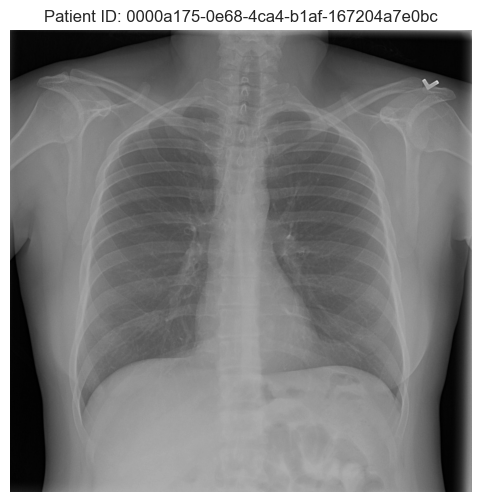

In [5]:
sample_dicom_path = os.path.join(test_images_dir, test_images[0])
id, image_array = get_dicom_image(sample_dicom_path, print_info=True)

# Display the image using matplotlib
plt.figure(figsize=(6,6))
plt.imshow(image_array, cmap='gray')
plt.title(f"Patient ID: {id}")
plt.axis('off')  # Hide axis ticks/labels
plt.show()

In [6]:
# Check for duplicates in train_labels
duplicates_train_labels = train_labels.duplicated().sum()
print(f"\nDuplicate rows in train_labels: {duplicates_train_labels}")

# Check for duplicate patient IDs specifically
duplicate_patient_ids = train_labels['patientId'].duplicated().sum()
print(f"Duplicate patient IDs in train_labels: {duplicate_patient_ids}")

# Check for duplicates in class_info
duplicates_class_info = class_info.duplicated().sum()
print(f"Duplicate rows in detailed_class_info: {duplicates_class_info}")

# Check duplicates in sample submission (should ideally be none)
duplicates_sample_submission = sample_submission.duplicated().sum()
print(f"Duplicate rows in sample_submission: {duplicates_sample_submission}")



Duplicate rows in train_labels: 0
Duplicate patient IDs in train_labels: 3543
Duplicate rows in detailed_class_info: 3543
Duplicate rows in sample_submission: 0


In [7]:
# Removing exact duplicates from train_labels
train_labels_cleaned = train_labels.drop_duplicates()
print(f"Rows before removing duplicates in train_labels: {len(train_labels)}")
print(f"Rows after removing duplicates in train_labels: {len(train_labels_cleaned)}")

# Removing exact duplicates from class_info
class_info_cleaned = class_info.drop_duplicates()
print(f"Rows before removing duplicates in class_info: {len(class_info)}")
print(f"Rows after removing duplicates in class_info: {len(class_info_cleaned)}")

# Sample submission typically should not have duplicates, remove if found
sample_submission_cleaned = sample_submission.drop_duplicates()
print(f"Rows before removing duplicates in sample_submission: {len(sample_submission)}")
print(f"Rows after removing duplicates in sample_submission: {len(sample_submission_cleaned)}")


Rows before removing duplicates in train_labels: 30227
Rows after removing duplicates in train_labels: 30227
Rows before removing duplicates in class_info: 30227
Rows after removing duplicates in class_info: 26684
Rows before removing duplicates in sample_submission: 3000
Rows after removing duplicates in sample_submission: 3000


### Step 2: Map Training and Testing Images to Their Classes.

#### Merge the cleaned train_labels and class_info DataFrames based on patientId.

In [8]:
# Merge train_labels with class_info to have labels and bounding boxes together
train_data_merged = pd.merge(train_labels_cleaned, class_info_cleaned, on='patientId', how='left')

# Check merged data
print("Merged DataFrame shape:", train_data_merged.shape)
print(train_data_merged.head())


Merged DataFrame shape: (30227, 7)
                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  


#### Inspect the distribution of class labels


Class distribution:
 class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


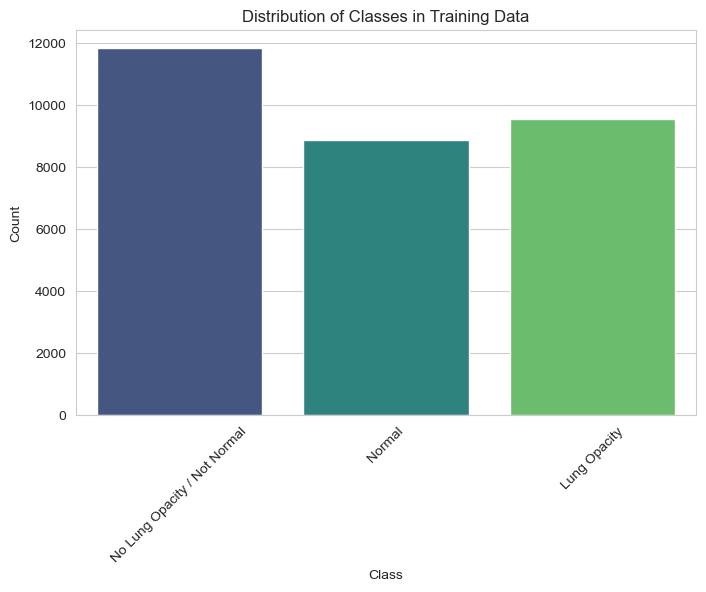

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution count
class_distribution = train_data_merged['class'].value_counts()
print("\nClass distribution:\n", class_distribution)

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=train_data_merged, palette='viridis', hue='class')
plt.title("Distribution of Classes in Training Data")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()


In [11]:
# Inspect the test set (sample submission file)
print("\nTest Set Sample Submission Preview:")
print(sample_submission_cleaned.head())



Test Set Sample Submission Preview:
                              patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100


### Step 3: Map Training Images to Their Annotations

#### Map patient IDs to their bounding boxes

In [12]:
# Group annotations by patientId clearly
annotations_grouped = train_labels_cleaned.groupby('patientId')

# Example: Display annotations for a specific patient clearly
sample_patient = train_labels_cleaned[train_labels_cleaned['Target'] == 1]['patientId'].iloc[0]

print(f"\nBounding Boxes for patientId '{sample_patient}':")
print(annotations_grouped.get_group(sample_patient))



Bounding Boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
                              patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1


In [13]:
# Create dictionary mapping patientId to list of bounding boxes (coordinates)
bbox_dict = {}

for patientId, group in annotations_grouped:
    bboxes = group[['x', 'y', 'width', 'height', 'Target']].values
    bbox_dict[patientId] = bboxes

# Verify clearly
print(f"Bounding boxes for patientId '{sample_patient}':")
print(bbox_dict[sample_patient])


Bounding boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
[[264. 152. 213. 379.   1.]
 [562. 152. 256. 453.   1.]]


C:\Users\nkpat\AppData\Local\Temp\ipykernel_7604\3572726885.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=bbox_counts, palette='coolwarm')


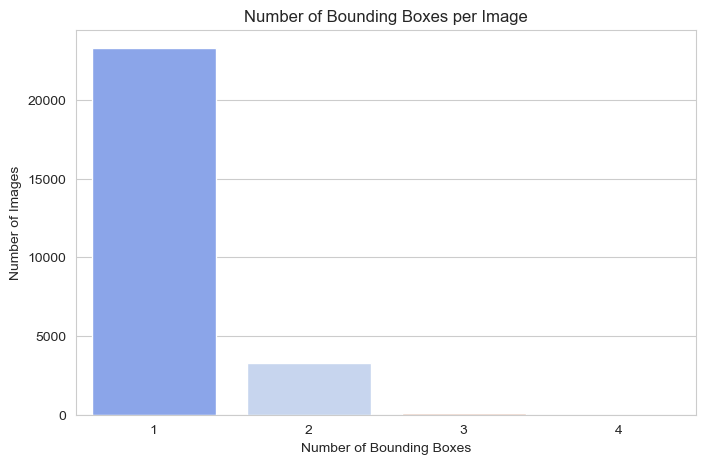

In [17]:
# Count number of bounding boxes per image
bbox_counts = annotations_grouped.size()

# Distribution clearly shown
plt.figure(figsize=(8,5))
sns.countplot(x=bbox_counts, palette='coolwarm')
plt.title("Number of Bounding Boxes per Image")
plt.xlabel("Number of Bounding Boxes")
plt.ylabel("Number of Images")
plt.show()
